C:\Users\DELL\AppData\Local\Temp/ipykernel_16708/630396412.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)
C:\Users\DELL\AppData\Local\Temp/ipykernel_16708/630396412.py:128: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
C:\Users\DELL\AppData\Local\Temp/ipykernel_16708/630396412.py:131: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
C:\Users\DELL\AppData\Local\Temp/ipykernel_16708/630396412.py:140: UserWarnin

Train accuracy: 0.576779 Test accuracy: 0.49565217


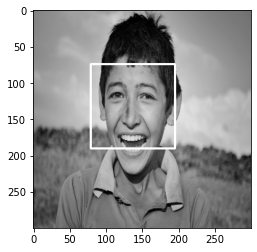

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.framework import ops
ops.reset_default_graph()
import cv2
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import sys
import shutil


folder_fake = 'C:/Users/DELL/Desktop/Newfolder/fake_smiles'
folder_real = 'C:/Users/DELL/Desktop/Newfolder/true_smiles'

def load_images_from_folder(folder):
    '''
    Input:
        folder             :The path of the image folder.
    Output:
        images             :A (N,) numpy array, where N is the total number of images.
    '''
    images = []
    for filename in os.listdir(folder):
        if filename.startswith('.') or filename == 'Thumbs.db':
            continue
        img = Image.open(os.path.join(folder,filename)).convert('L') # open the image and convert to uint8 (gray scale)
        img = np.array(img) # convert image to a numpy array
        if img is not None:
            images.append(img)
    images = np.array(images)
    return images

def resize_image(images, size):
    '''
    Input: 
        images             :An object of shape (N,). N is the total number of images.
        size               :A ndarray (rows, cols) of the output image shape.
    Output:
        resized_images     :An (N,rows,cols) numpy array.
    '''
    resized_images = []
    for i,j in enumerate(images):
        resized_images.append(resize(images[i], ((size[0]),size[1]), mode='reflect')) # resize the image
    resized_images = np.array(resized_images) # convert image to a numpy array
    return resized_images

def detectFace(img):
    '''
    Input:
        img                 : A gray scale image represented by numpy array.
    Output:
        bbox                : The four corners of bounding boxes for all detected faces in numpy arrray of shape (number of detected faces,4,2).
                                ++++++++++++++++++
                                +(x0,y0)  (x1,y1)+
                                +                +
                                +                +
                                +      bbox      +
                                +                +
                                +                +
                                +(x2,y2)  (x3,y3)+
                                ++++++++++++++++++
    '''
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
	
    faces = face_cascade.detectMultiScale(img, 1.3, 4)
    bbox = np.zeros([len(faces),4,2])
        
    for i, (x,y,w,h) in enumerate(faces):
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # draw a rectangle around the face  
        bbox[i,:,:] = np.array([[y,x],[y,x+w],[y+h,x],[y+h,x+w]])
        
    plt.figure()
    plt.imshow(img, cmap='gray')
    
    return bbox.astype(int)

new_size = [300,300] # the output size of all the images regardless of its original shape
images = load_images_from_folder(folder_fake)
X_fake = resize_image(images,new_size)
y_fake = np.ones([X_fake.shape[0]])

images = load_images_from_folder(folder_real)
X_real = resize_image(images,new_size)
y_real = np.zeros([X_real.shape[0]])

bbox = detectFace((255*X_real[10]).astype('uint8')) # detects the face of the 10th image

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

height = new_size[0]
width = new_size[1]
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_fmaps = 16
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_fmaps = 50
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 2

reset_graph()

#with tf.device('/cpu:0'):
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 5625]) # 5625 = 300*300*4 / pool3_fmaps

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
        
n_epochs = 10

with tf.Session() as sess:
    init.run()
    X_raw = np.r_[X_fake, X_real]
    y_raw = np.r_[y_fake, y_real] # the labels, 1: fake, 0: real
	
#    for epoch in range(n_epochs):
#        X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3)
#        sess.run(training_op, feed_dict={X: X_train, y: y_train})
#		
#        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
#        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
#        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3) 
    sess.run(training_op, feed_dict={X: X_train, y: y_train})	
    acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train}) 
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test}) 
    print("Train accuracy:", acc_train, "Test accuracy:", acc_test) 
#    summary_writer.add_summary(filter_summary)
    
    shutil.rmtree(folder_results_fake_test, ignore_errors=True)                 # remove the folder if it already exists
    os.makedirs(folder_results_fake_test)                                       # create a new folder
    shutil.rmtree(folder_results_real_test, ignore_errors=True)                 # remove the folder if it already exists
    os.makedirs(folder_results_real_test)                                       # create a new folder
    
    for i,j in np.ndenumerate(pred_fake_indices_test):                          # save all the predicted "fake" samples into the folder
        plt.imsave(folder_results_fake_test+"/fake_smile_pred_test_"+str(i[1])
                                            +".jpg",X_test[j,:,:], cmap='gray')
    for i,j in np.ndenumerate(pred_real_indices_test):                          # save all the predicted "real" samples into the folder
        plt.imsave(folder_results_real_test+"/real_smile_pred_test_"+str(i[1])
                                            +".jpg",X_test[j,:,:], cmap='gray')
